In [14]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from scipy import stats
import seaborn as sns
from functools import reduce
pd.options.mode.chained_assignment = None 
from statistics import mean
from Profile_Generation import *
from plotting import *
from analysis import *
import warnings
warnings.simplefilter('ignore', np.RankWarning)
from scipy.optimize import curve_fit
import matplotlib.patches as patches
from scipy.optimize import curve_fit
from openpyxl import load_workbook
import math
from scipy.optimize import OptimizeWarning
warnings.simplefilter("ignore", OptimizeWarning)
import timeit
from sklearn.metrics import mean_squared_error
from matplotlib.pyplot import cm
from matplotlib.patches import Patch
from scipy import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
%%time
# ~5mins

# Execute CURATE without pop tau
execute_CURATE(pop_tau_string='_by_body_weight_2')

Patient #117 has insufficient/<3 predictions (1 predictions) (for linear)!
Patient #117 has insufficient/<3 predictions (0 predictions) (for quadratic)!
Patient #121 has insufficient unique dose-response pairs for calibration (for quad)!
Patient #126 has insufficient unique dose-response pairs for calibration (for quad)!
Patient #130 has insufficient/<3 predictions (2 predictions) (for linear)!
Patient #130 has insufficient/<3 predictions (1 predictions) (for quadratic)!
Patient #133 has insufficient/<3 predictions (0 predictions) (for linear)!
Patient #133 has insufficient unique dose-response pairs for calibration (for quad)!
Patients to exclude for linear methods: ['117', '130', '133']
Patients to exclude for quad methods: ['117', '121', '126', '130', '133']
Wall time: 11min 11s


In [25]:
clean = pd.read_excel('output_dose_by_body_weight.xlsx', sheet_name='clean')

In [30]:
dat = clean.copy()
dat.dose.describe()

count    162.000000
mean       0.201759
std        0.136423
min        0.000000
25%        0.108401
50%        0.170940
75%        0.294031
max        0.540541
Name: dose, dtype: float64

In [2]:
result = pd.read_excel('output_dose_by_body_weight.xlsx', sheet_name='result')

In [3]:
dat = result.copy()
dat[dat.method=='L_RW_wo_origin']['prediction'].describe()

count    119.000000
mean       8.941176
std        3.026169
min        2.800000
25%        6.900000
50%        9.000000
75%       10.900000
max       17.600000
Name: prediction, dtype: float64

In [5]:
df = CURATE_could_be_useful()

In [35]:
21/119*100

17.647058823529413

In [ ]:
%%time
# Perform CV
five_fold_cross_val_results, five_fold_cross_val_results_summary = find_pop_tau_with_CV()
execute_CURATE_and_update_pop_tau_results('CV', five_fold_cross_val_results_summary, five_fold_cross_val_results)

# Perform LOOCV
five_fold_cross_val_results, five_fold_cross_val_results_summary = find_pop_tau_with_LOOCV()
execute_CURATE_and_update_pop_tau_results('LOOCV', five_fold_cross_val_results_summary, five_fold_cross_val_results)

In [ ]:
# Profile Generation
input_file = 'Retrospective Liver Transplant Data.xlsx'
rows_to_skip = 17

# Get list of patients/sheet names
list_of_patients = get_sheet_names(input_file)

# Define lists
list_of_patient_df = []
list_of_cal_pred_df = []
list_of_result_df = []
patients_to_exclude_linear = []
patients_to_exclude_quad = []
list_of_body_weight = []

# Create list of body_weight
for i in range(len(list_of_patients)):    
    data = pd.read_excel('Retrospective Liver Transplant Data.xlsx', list_of_patients[i], index_col=None, usecols = "C", nrows=15)
    data = data.reset_index(drop=True)
    list_of_body_weight.append(data['Unnamed: 2'][13])
    
list_of_body_weight = list_of_body_weight[:12]+[8.29]+list_of_body_weight[12+1:]

number_of_patients = 0

for patient in list_of_patients:

    # Create and clean patient dataframe        
    df = pd.read_excel(input_file, sheet_name=patient, skiprows=rows_to_skip)
    df = clean_data(df, patient)
    df = keep_ideal_data(df, patient, list_of_patient_df)
    
    # Change to dose by body weight
    df['dose'] = df['dose'] / list_of_body_weight[number_of_patients]
    
    # Counter for number of patients
    number_of_patients = number_of_patients + 1
    
list_of_patient_df

In [ ]:


list_of_body_weight

In [ ]:
file_string='all_data_including_non_ideal.xlsx'
plot=True

# Plot individual profiles
dat = pd.read_excel(file_string, sheet_name='clean')

# Create within-range column for color
dat['within_range'] = (dat.response <= 10) & (dat.response >= 8)

# Create low/med/high dose column
dat['dose_range'] = ""
for i in range(len(dat)):
    if dat.dose[i] < 2:
        dat.loc[i, 'dose_range'] = 'Low'
    elif dat.dose[i] < 4:
        dat.loc[i, 'dose_range'] = 'Medium'
    else:
        dat.loc[i, 'dose_range'] = 'High'

# Rename columns and entries
new_dat = dat.copy()
new_dat = new_dat.rename(columns={'within_range':'Tacrolimus Levels'})
new_dat['Tacrolimus Levels'] = new_dat['Tacrolimus Levels'].map({True:'Therapeutic Range', False: 'Non-therapeutic Range'})
new_dat = new_dat.rename(columns={'dose_range':'Dose range', 'day':'Day'})
new_dat['patient'] = new_dat['patient'].map({84:1, 114:2, 117:3, 118:4, 120:5, 121:6, 122:7,
                                            123:8, 125:9, 126:10, 129:11, 130:12, 131:13, 132:14,
                                            133:15, 138:16})

if plot == True:

    # Plot dose vs response
    sns.set(font_scale=1.2, rc={"figure.figsize": (16,10), "xtick.bottom" : True, "ytick.left" : True}, style='white')

    plot = plt.scatter(new_dat.dose, new_dat.response, c=new_dat.Day, cmap=sns.cubehelix_palette(as_cmap=True))
    plt.clf()
    cbar = plt.colorbar(plot)
    cbar.ax.tick_params(labelsize=20) 

    plt.savefig('colorbar.png', dpi=500, facecolor='w', bbox_inches='tight')

#     g = sns.relplot(data=new_dat, x='dose', y='response', hue='Day', col='patient', col_wrap=4, style='Dose range',
#             height=3, aspect=1,s=80)

#     # Add gray region for therapeutic range
#     for ax in g.axes:
#         ax.axhspan(8, 10, facecolor='grey', alpha=0.2)
        
#     g.set_titles('Patient {col_name}')
#     g.set_ylabels('Tacrolimus level (ng/ml)')
#     g.set_xlabels('Dose')
#     g.set(yticks=np.arange(0,math.ceil(max(new_dat.response)),4),
#         xticks=np.arange(0, max(new_dat.dose+1), step=1))

#     plt.savefig('indiv_pt_profile_by_dose.png', dpi=500, facecolor='w', bbox_inches='tight')

No handles with labels found to put in legend.


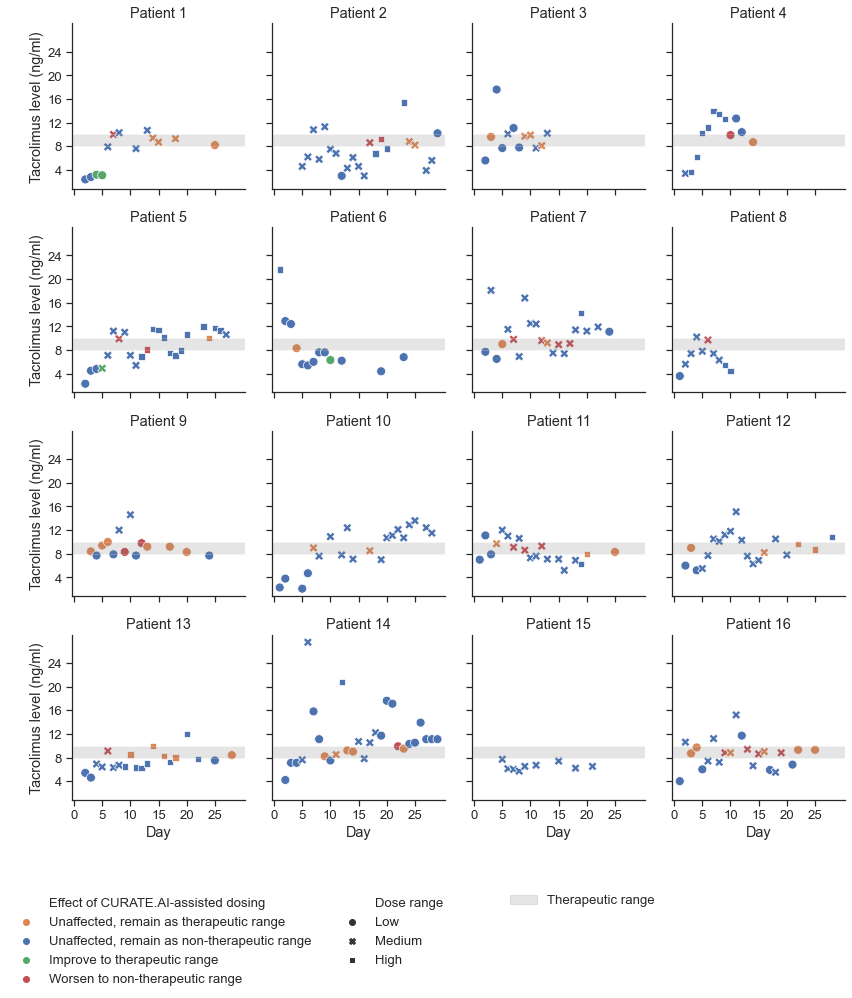

In [58]:
df = effect_of_CURATE_RW()

In [ ]:
dat = df.copy()

,Day,Tacrolimus level (ng/ml),dose,patient,ideal,within_range,Dose range,Effect of CURATE.AI-assisted dosing
13,5,4.6,2.0,2,True,False,Medium,"Unaffected, remain as non-therapeutic range"
14,6,6.2,2.5,2,True,False,Medium,"Unaffected, remain as non-therapeutic range"
15,7,10.8,3.0,2,True,False,Medium,"Unaffected, remain as non-therapeutic range"
16,8,5.8,3.0,2,True,False,Medium,"Unaffected, remain as non-therapeutic range"
17,9,11.3,3.5,2,True,False,Medium,"Unaffected, remain as non-therapeutic range"
18,10,7.5,2.0,2,True,False,Medium,"Unaffected, remain as non-therapeutic range"
19,11,6.8,2.0,2,True,False,Medium,"Unaffected, remain as non-therapeutic range"
20,12,3.0,1.0,2,True,False,Low,"Unaffected, remain as non-therapeutic range"
21,13,4.3,2.0,2,True,False,Medium,"Unaffected, remain as non-therapeutic range"
22,14,6.1,3.0,2,True,False,Medium,"Unaffected, remain as non-therapeutic range"


No handles with labels found to put in legend.


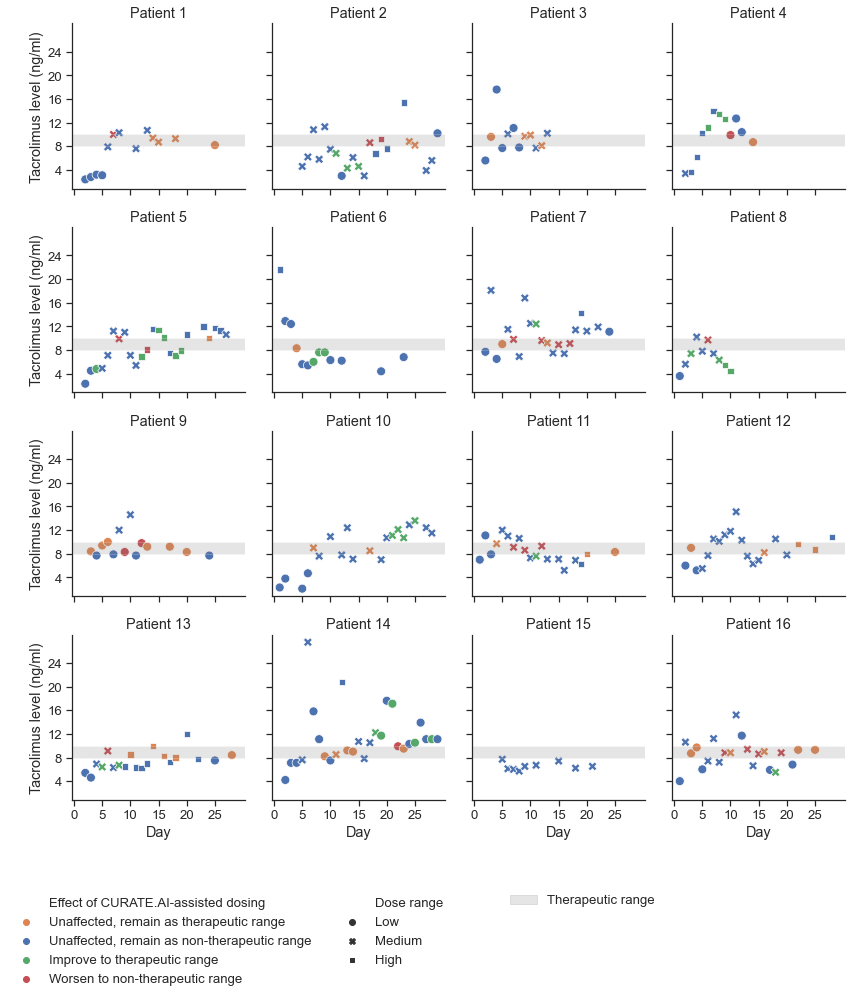

In [92]:
df = effect_of_CURATE_RW()

Text(0, 0.5, 'Patients that achieved\ntherapeutic range in first week')

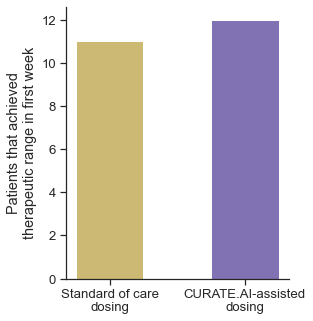

In [152]:
dat = df.copy()

# Keep within_range only
dat_SOC_within_range = dat[dat.within_range==True].reset_index(drop=True)

# Find first day to achieve therapeutic range in SOC
SOC = dat_SOC_within_range.groupby('patient')['Day'].first().to_frame()

SOC_achieve_TR_in_first_week = SOC <= 7

# Keep those that are 1) unaffected by in TR and 2) improve to TR
dat_CURATE_within_range = dat[(dat['Effect of CURATE.AI-assisted dosing']=='Unaffected, remain as therapeutic range') |
                             (dat['Effect of CURATE.AI-assisted dosing']=='Improve to therapeutic range')].reset_index(drop=True)

# Find first day to achieve therapeutic range in CURATE
CURATE = dat_CURATE_within_range.groupby('patient')['Day'].first().to_frame()

CURATE_achieve_TR_in_first_week = CURATE <= 7

# Create dataframe with vales
plot_data = pd.Series({'Standard of care\ndosing': SOC_achieve_TR_in_first_week.sum()[0], 'CURATE.AI-assisted\ndosing':CURATE_achieve_TR_in_first_week.sum()[0]}).to_frame().reset_index()
plot_data.columns = ['Dosing', 'Patients that achieved therapeutic range in first week']

sns.set(font_scale=1.2, rc={"figure.figsize": (4,5), "xtick.bottom":True, "ytick.left":True}, style='white')
fig, ax = plt.subplots()
ax.bar(plot_data['Dosing'], plot_data['Patients that achieved therapeutic range in first week'], width=0.5, color=['y', 'm'])
sns.despine()
plt.ylabel('Patients that achieved\ntherapeutic range in first week')

# CURATE_achieve_TR_in_first_week.sum()[0]

# combined = SOC.merge(CURATE, how='left', on='patient')
# combined.columns=['SOC', 'CURATE']

# combined = combined.stack().to_frame().reset_index()
# combined.columns = ['patient', 'Dosing', 'Days to first therapeutic range']
# combined['Dosing'] = combined['Dosing'].replace({'SOC':'Standard of care', 'CURATE':'CURATE.AI-assisted'})

# sns.set(font_scale=1.2, rc={"figure.figsize": (5,5), "xtick.bottom":True, "ytick.left":True}, style='white')
# g = sns.boxplot(x="Dosing", y="Days to first therapeutic range", data=combined, width=0.5, palette=['#ccb974','#8172b3'])
# sns.despine()